In [142]:
import csv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import networkx.algorithms.community as nx_comm
from cdlib import evaluation, algorithms
from cdlib import NodeClustering
import pandas as pd
import community
from cdlib import algorithms
import matplotlib
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from collections import Counter
from statistics import mean

In [143]:
#reads the csv
stocks = pd.read_csv('Prices2019.csv')
#craetes a correlation matrix
cor_matrix = stocks.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix.head()
cor_matrix.to_csv('output.csv')

In [144]:
#extracts the indices from the correlation matrix, which are the stocks
stocks = cor_matrix.index.values

In [145]:
# Create an array to store the upper triangular part of the correlation matrix
upper_triangle = np.triu(cor_matrix, k=1)

# Find the indices (i, j) of the maximum and minimum values in the upper triangular part
max_idx = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
min_idx = np.unravel_index(np.argmin(upper_triangle), upper_triangle.shape)

# Get the maximum and minimum values
max_value = upper_triangle[max_idx]
min_value = upper_triangle[min_idx]

# Get the respective entry names (i, j)
max_entry = (max_idx[0], max_idx[1])
min_entry = (min_idx[0], min_idx[1])

# Print the results
print(f"Maximum correlation ({max_value}) is between entries {max_entry}")
print(f"Minimum correlation ({min_value}) is between entries {min_entry}")

Maximum correlation (0.9651140394921512) is between entries (11, 12)
Minimum correlation (-0.9146726711400182) is between entries (10, 11)


In [146]:
# convert matrix to list of edges and rename the columns
edges = cor_matrix.stack().reset_index()
edges.columns = ["asset_1", "asset_2", "correlation"]

# remove self correlations
edges = edges.loc[edges["asset_1"] != edges["asset_2"]].copy()

# show the first 5 rows of the edge list dataframe.
edges.head()


,asset_1,asset_2,correlation
1,AFIN,AINM,-0.294012
2,AFIN,ALLI,0.939396
3,AFIN,AMMB,0.925110
4,AFIN,ANCR,0.713283
5,AFIN,APES,0.788957


In [147]:
#threshold
#extracts the indices from the correlation matrix, which are the stocks
stocks = cor_matrix.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
corr_matrix = np.asmatrix(cor_matrix)

c1 = corr_matrix.mean()
c2 = corr_matrix.std()

positive_threshold = c1+c2
negative_threshold = c1-c2

print("Mean:",c1,"Std dev:",c2, "Positive threshold:",positive_threshold, "Negative threshold:",negative_threshold)

Mean: 0.20524775947666912 Std dev: 0.5089865790784204 Positive threshold: 0.7142343385550896 Negative threshold: -0.30373881960175125


In [148]:
# create undirected graph with weights corresponding to the correlation magnitude
G0 = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# print out the graph info
# check number of nodes and degrees are as expected
# (all should have degree = 29, i.e. average degree = 29)
print(nx.info(G0))


Name: 
Type: Graph
Number of nodes: 30
Number of edges: 435
Average degree:  29.0000


In [149]:
threshold = 0.7142

# create a new graph from edge list
Gx = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# list to store edges to remove
remove = []
# loop through edges in Gx and find correlations which are below the threshold
for asset_1, asset_2 in Gx.edges():
    corr = Gx[asset_1][asset_2]["correlation"]
    # add to remove node list if abs(corr) < threshold
    if abs(corr) < threshold:
        remove.append((asset_1, asset_2))

# remove edges contained in the remove list
Gx.remove_edges_from(remove)

print(str(len(remove)) + " edges removed")


335 edges removed


In [150]:
# Set edge attributes based on weight sign
edge_attributes = {}
for u, v, weight in Gx.edges(data=True):
    direction = 'positive' if weight['correlation'] >= 0 else 'negative'
    edge_attributes[(u, v)] = direction

# Set the edge attributes in the graph
nx.set_edge_attributes(Gx, edge_attributes, name='direction')

In [151]:
#find community

from community import community_louvain, modularity

Graph_list = []
part = []
modular = []
for _ in range(100):
    G = Gx.copy()
    P = community_louvain.best_partition(G,weight='weight')
    M = modularity(P, G, weight='weight')
    Graph_list.append(G)
    part.append(P)
    modular.append(M) 


In [152]:
df_partition = pd.DataFrame(part)
df_partition_idmax = df_partition.value_counts().idxmax()
df_modular = pd.DataFrame(modular)

In [153]:
# Calculate the mean of the modularity
mean_value = df_modular.mean()

print("Mean of the column:", mean_value)

Mean of the column: 0    0.069531
dtype: float64


In [154]:
density = nx.density(Gx) #calculate network density
print("Network density:", density)
print(nx.info(Gx))

Network density: 0.22988505747126436
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 100
Average degree:   6.6667


In [155]:
xy_labelm = pd.read_csv('Stock_label_m.csv')
xy_labelm.head()

,Id,Subsektor
0,AFIN,Bank
1,AINM,Insurans
2,ALLI,Bank
3,AMMB,Bank
4,ANCR,Perkhidmatan kewangan lain


In [156]:
stock_to_subsector = dict(zip(xy_labelm['Id'], xy_labelm['Subsektor']))
nx.set_node_attributes(Gx, stock_to_subsector, 'subsector')


In [157]:
abs_weights = {(u, v): abs(d["correlation"]) for u, v, d in Gx.edges(data=True)}
nx.set_edge_attributes(Gx, abs_weights, "weight")

In [158]:
degree_dict = {n: d for n, d in Gx.degree()} # Run degree
dede_dict = nx.degree_centrality(Gx)
ndegree_dict = {n: d for n, d in Gx.degree(weight="weight")} # Run weighted degree
betweenness_dict = nx.betweenness_centrality(Gx) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(Gx) # Run eigenvector centrality
closeness_dict = nx.closeness_centrality(Gx) # Run closeness centrality

# Assign each to an attribute in your network
nx.set_node_attributes(Gx, betweenness_dict, 'betweenness')
nx.set_node_attributes(Gx, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(Gx, closeness_dict, 'closeness')
nx.set_node_attributes(Gx, degree_dict, 'degree')
nx.set_node_attributes(Gx, ndegree_dict, 'ndegree')
nx.set_node_attributes(Gx, dede_dict, 'dede')


In [159]:
att = pd.DataFrame([i[1] for i in Gx.nodes(data=True)], index=[i[0] for i in Gx.nodes(data=True)])
att.to_csv('Centralities_2019.csv', index=True) #save to new file
att = pd.read_csv('Centralities_2019.csv')
att = att.rename(columns={att.columns[0]: 'stock'})

In [160]:
att.head()

,stock,subsector,betweenness,eigenvector,closeness,degree,ndegree,dede
0,AFIN,Bank,0.002851,2.717648e-01,0.485757,13,11.438768,0.448276
1,AINM,Insurans,0.000000,2.279062e-10,0.000000,0,0.000000,0.000000
2,ALLI,Bank,0.006723,2.830126e-01,0.507837,14,12.550071,0.482759
3,AMMB,Bank,0.006723,2.830126e-01,0.507837,14,11.920048,0.482759
4,ANCR,Perkhidmatan kewangan lain,0.014439,1.518260e-01,0.385256,8,6.123409,0.275862


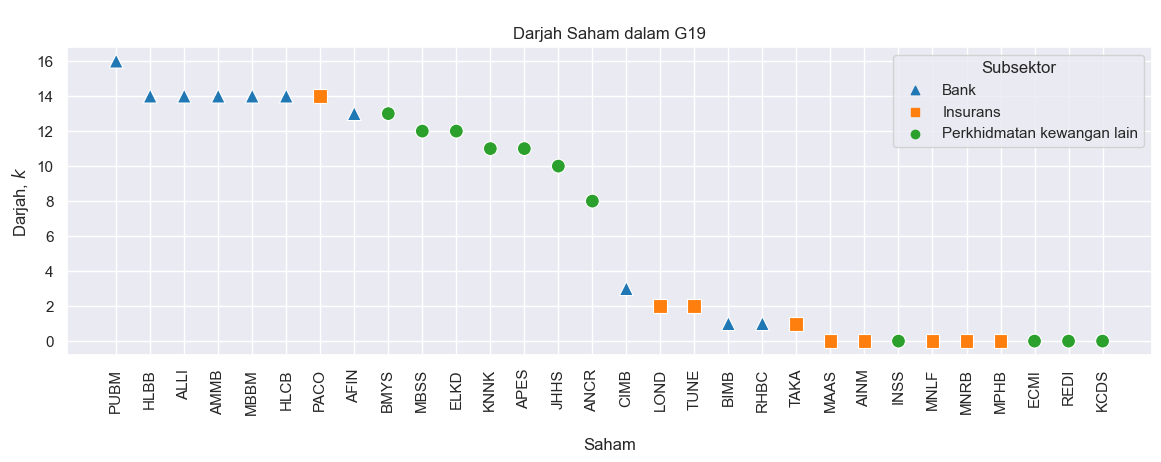

In [161]:
sns.set_theme()
degree_sorted = att.sort_values(by='degree', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}
# Define a consistent color palette for the subsectors
palette = {
    'Bank': '#1f77b4',
    'Insurans': '#ff7f0e',
    'Perkhidmatan kewangan lain': '#2ca02c'
}

# Define the order of the subsectors in the legend
hue_order = ['Bank', 'Insurans', 'Perkhidmatan kewangan lain']

# Map the marker shapes to the subsectors
degree_sorted['Marker'] = degree_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=degree_sorted,
    x='stock',
    y='degree',
    hue='subsector',# Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title('\nDarjah Saham dalam G19')
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Darjah, $k$')

# Show legend
plt.legend(title='Subsektor')

plt.savefig('Darjah_2019.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


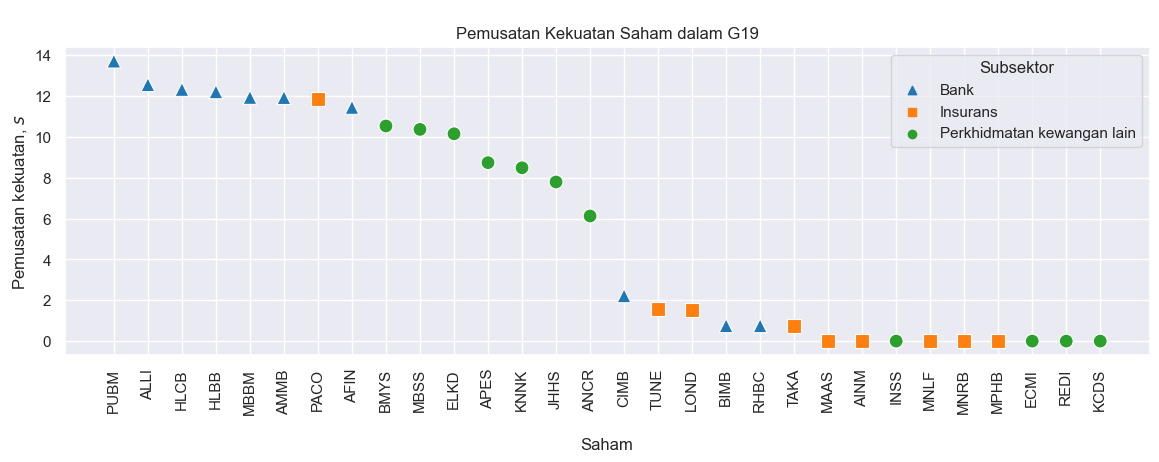

In [162]:
ndegree_sorted = att.sort_values(by='ndegree', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
ndegree_sorted['Marker'] = ndegree_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=ndegree_sorted,
    x='stock',
    y='ndegree',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title('\nPemusatan Kekuatan Saham dalam G19')
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan kekuatan, $s$')

# Show legend
plt.legend(title='Subsektor')

#plt.savefig('Darjah_berpemberat_2019.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


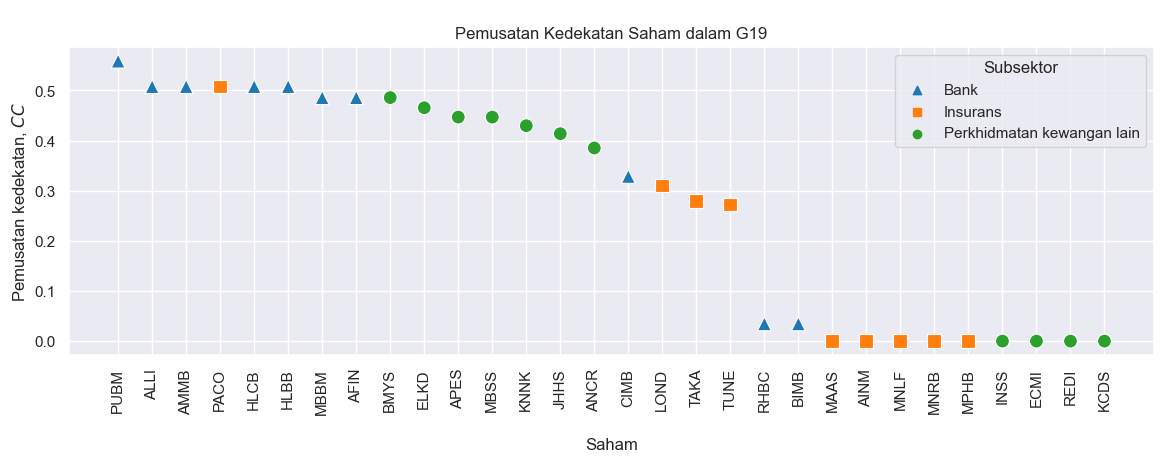

In [163]:
closeness_sorted = att.sort_values(by='closeness', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
closeness_sorted['Marker'] = closeness_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=closeness_sorted,
    x='stock',
    y='closeness',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title('\nPemusatan Kedekatan Saham dalam G19')
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan kedekatan, $CC$')

# Show legend
plt.legend(title='Subsektor')

#plt.savefig('Pemusatan_Kedekatan_2019.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


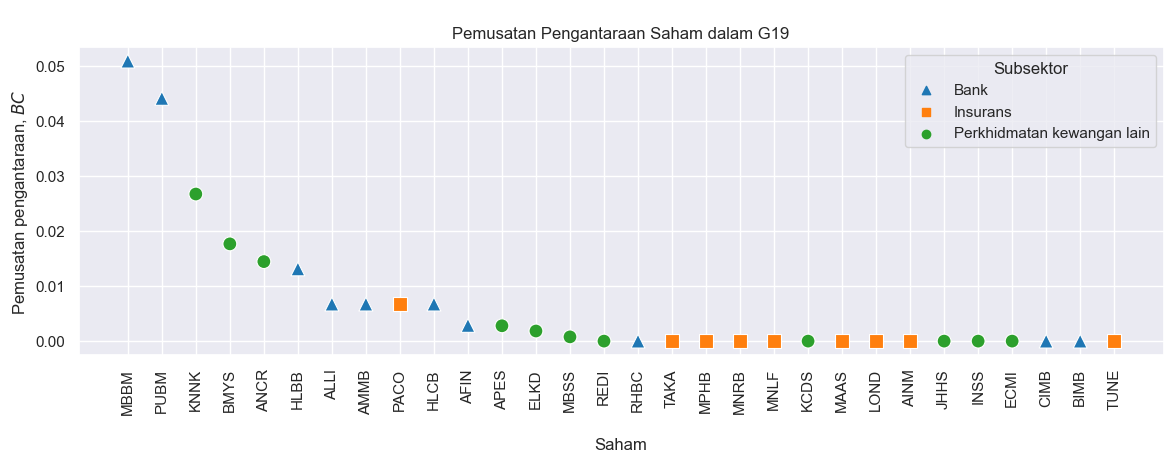

In [164]:
betweenness_sorted = att.sort_values(by='betweenness', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
betweenness_sorted['Marker'] = betweenness_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=betweenness_sorted,
    x='stock',
    y='betweenness',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title('\nPemusatan Pengantaraan Saham dalam G19')
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan pengantaraan, $BC$')

# Show legend
plt.legend(title='Subsektor')

#plt.savefig('Pemusatan_Pengantaraan_2019.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


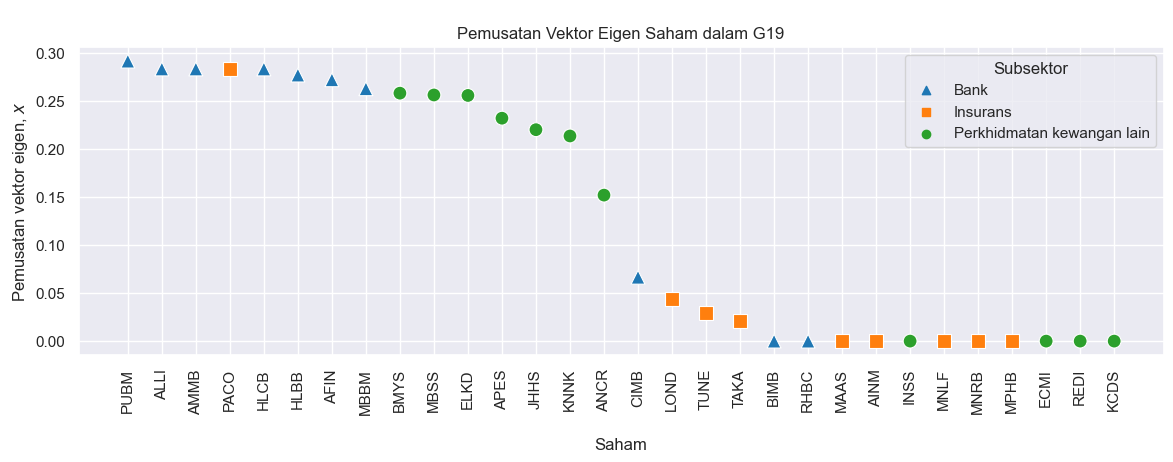

In [165]:
eigenvector_sorted = att.sort_values(by='eigenvector', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
eigenvector_sorted['Marker'] = eigenvector_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=eigenvector_sorted,
    x='stock',
    y='eigenvector',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title('\nPemusatan Vektor Eigen Saham dalam G19')
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan vektor eigen, $x$')

# Show legend
plt.legend(title='Subsektor')

#plt.savefig('Pemusatan_Vektoreigen_2019.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


In [166]:
from operator import itemgetter
sorted_in_degree = sorted(ndegree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by in degree:")
for a in sorted_in_degree[:10]:
    print(a)

Top 10 nodes by in degree:
('PUBM', 13.70408892932816)
('ALLI', 12.550070755850456)
('HLCB', 12.316700106752446)
('HLBB', 12.199887029042236)
('MBBM', 11.925899416734637)
('AMMB', 11.92004791236476)
('PACO', 11.843226604537788)
('AFIN', 11.438768373072206)
('BMYS', 10.528288253335951)
('MBSS', 10.361274750007725)


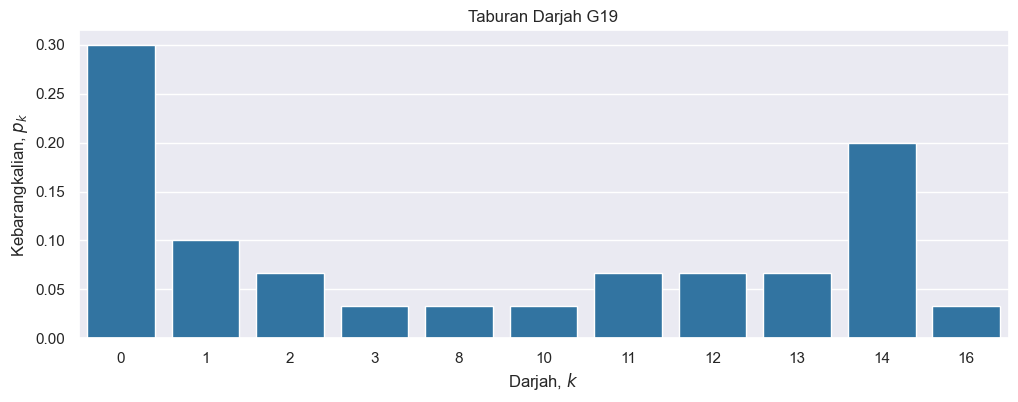

In [167]:
#sns.set_style("white")
# Calculate the degree for each node
degrees = pd.DataFrame(Gx.degree(), columns=['Node', 'Degree'])

# Calculate the degree distribution
degree_counts = degrees['Degree'].value_counts().sort_index()
total_nodes = len(degrees)

# Calculate the probability
degree_prob = degree_counts / total_nodes

# Plotting
plt.figure(figsize=(12, 4))
sns.barplot(x=degree_prob.index, y=degree_prob.values, color='#1f77b4')
plt.title('Taburan Darjah G19')
plt.xlabel(r'Darjah, $k$')
plt.ylabel(r'Kebarangkalian, $p_k$')
#plt.savefig('Taburan_darjah_2019.jpg',dpi=500,bbox_inches = 'tight')
plt.show()


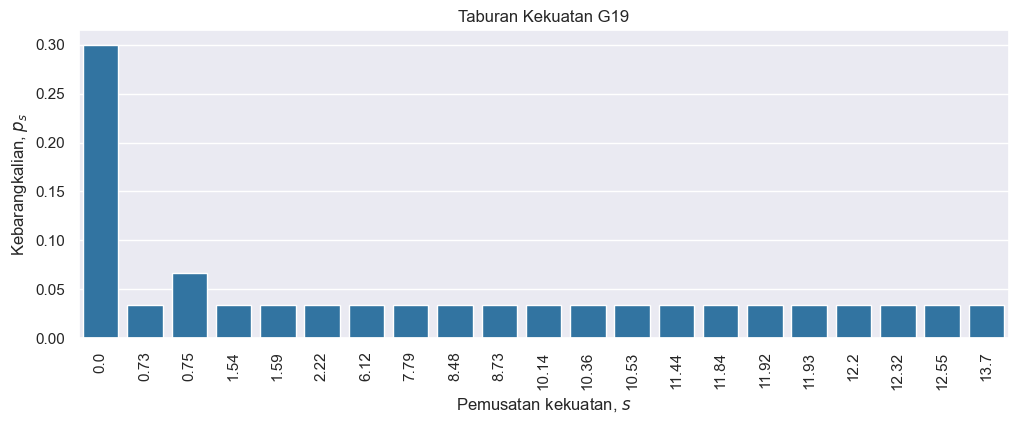

In [168]:
#sns.set_style("white")
# Calculate the degree for each node
degrees = pd.DataFrame(Gx.degree(weight='weight'), columns=['Node', 'Degree'])

# Round the weighted degrees to two decimal places
degrees['Degree'] = degrees['Degree'].round(2)

# Calculate the degree distribution
degree_counts = degrees['Degree'].value_counts().sort_index()
total_nodes = len(degrees)

# Calculate the probability
degree_prob = degree_counts / total_nodes

# Plotting
plt.figure(figsize=(12, 4))
sns.barplot(x=degree_prob.index, y=degree_prob.values, color='#1f77b4')
plt.title('Taburan Kekuatan G19')
plt.xlabel(r'Pemusatan kekuatan, $s$')
plt.ylabel(r'Kebarangkalian, $p_s$')
# Rotate x-axis labels and format to two decimal points
plt.xticks(rotation=90)
#plt.gca().set_xticklabels([f'{x:.2f}' for x in degree_prob.index])
#plt.savefig('Taburan_darjah_berpemberat_2019.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


In [169]:
df2 = pd.DataFrame(df_partition_idmax, columns=['Partition'])
df1 = pd.DataFrame(stocks, columns=['node'])

modular_id = pd.concat([df1,df2], axis=1)
modular_id

,node,Partition
0,AFIN,0
1,AINM,1
2,ALLI,0
3,AMMB,0
4,ANCR,2
5,APES,0
6,BIMB,3
7,BMYS,5
8,CIMB,5
9,ECMI,6


In [170]:
modular_id['Partition'].value_counts()

0     10
5      6
2      3
3      2
1      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
4      1
Name: Partition, dtype: int64

In [171]:
# Convert the partition DataFrame to a dictionary with node attributes
node_attributes = modular_id.set_index('node')['Partition'].to_dict()

# Set the node attributes in the graph
nx.set_node_attributes(Gx, node_attributes, name='Partition')

In [172]:

# Create an empty dictionary to store the internal edge densities for each community
internal_edge_densities = {}

# Iterate through the communities in Partition
for community_id in set(nx.get_node_attributes(Gx, 'Partition').values()):
    # Create a subgraph for the current community
    community_nodes = [node for node, partition in nx.get_node_attributes(Gx, 'Partition').items() if partition == community_id]
    community_subgraph = Gx.subgraph(community_nodes)

    # Calculate the number of internal edges in the community
    internal_edges = 0
    for edge in community_subgraph.edges():
        if edge[0] in community_nodes and edge[1] in community_nodes:
            internal_edges += 1

    # Calculate the number of possible internal edges in the community
    possible_internal_edges = len(list(combinations(community_nodes, 2)))

    # Calculate the internal edge density for the community
    if possible_internal_edges > 0:
        internal_edge_density = internal_edges / possible_internal_edges
    else:
        internal_edge_density = 0.0

    # Store the internal edge density in the dictionary
    internal_edge_densities[community_id] = internal_edge_density

# Calculate the average internal edge density for all communities
average_internal_edge_density = sum(internal_edge_densities.values()) / len(internal_edge_densities)

print("Internal Edge Densities for Communities:")
for community_id, density in internal_edge_densities.items():
    print(f"Community {community_id}: {density:.4f}")

print(f"Average Internal Edge Density: {average_internal_edge_density:.4f}")


Internal Edge Densities for Communities:
Community 0: 0.9556
Community 1: 0.0000
Community 2: 1.0000
Community 3: 1.0000
Community 4: 0.0000
Community 5: 0.5333
Community 6: 0.0000
Community 7: 0.0000
Community 8: 0.0000
Community 9: 0.0000
Community 10: 0.0000
Community 11: 0.0000
Community 12: 0.0000
Average Internal Edge Density: 0.2684


In [173]:
G19_coms = NodeClustering(community19, graph=None, method_name="G19")
print(f'Internal edge density for G19: {evaluation.internal_edge_density(Gx,G19_coms)}')


Internal edge density for G19: FitnessResult(min=0, max=1.0, score=0.19814814814814816, std=0.35282030462055003)


In [174]:
# Group nodes based on their partitions and convert the groups into lists
community19 = modular_id.groupby('Partition')['node'].apply(list).tolist()

print("Community19:", community19)

Community19: [['AFIN', 'ALLI', 'AMMB', 'APES', 'ELKD', 'HLBB', 'HLCB', 'JHHS', 'MBSS', 'PACO'], ['AINM'], ['ANCR', 'KNNK', 'TUNE'], ['BIMB', 'RHBC'], ['REDI'], ['BMYS', 'CIMB', 'LOND', 'MBBM', 'PUBM', 'TAKA'], ['ECMI'], ['INSS'], ['KCDS'], ['MAAS'], ['MNLF'], ['MNRB'], ['MPHB']]


In [175]:
# Calculate Network Transitivity
transitivity = nx.transitivity(Gx)
print("Network Transitivity:", transitivity)

# Calculate Average Clustering Coefficient
avg_clustering = nx.average_clustering(Gx)
print("Average Clustering Coefficient:", avg_clustering)


Network Transitivity: 0.830122591943958
Average Clustering Coefficient: 0.520079365079365


In [176]:
avg_weighted_clustering = nx.average_clustering(Gx,weight='weight')
print("Average Weighted Clustering Coefficient:", avg_weighted_clustering)

Average Weighted Clustering Coefficient: 0.450996566950777


In [177]:
xy_label = pd.read_csv('Stock_label.csv')
xy_label.head()

,Id,Subsector
0,AFIN,Banking
1,AINM,Insurance
2,ALLI,Banking
3,AMMB,Banking
4,ANCR,Other Financials


In [178]:
#color_replacements = {"Banking": "red", "Insurance": "blue", "Other Financials": "green"}
#xy_label["color"] = xy_label["Subsector"].replace(color_replacements)
shape_emoji = {
    "Other Financials": "●",
    "Insurance": "■",
    "Banking": "▲",
    # Add more mappings for other shapes
}
xy_label["shape"] = xy_label["Subsector"].replace(shape_emoji)

xy_label.head()

,Id,Subsector,shape
0,AFIN,Banking,▲
1,AINM,Insurance,■
2,ALLI,Banking,▲
3,AMMB,Banking,▲
4,ANCR,Other Financials,●


In [179]:
#color_replacements = {"Banking": "red", "Insurance": "blue", "Other Financials": "green"}
#xy_label["color"] = xy_label["Subsector"].replace(color_replacements)
shape_emojim = {
    "Perkhidmatan kewangan lain": "●",
    "Insurans": "■",
    "Bank": "▲",
    # Add more mappings for other shapes
}
xy_labelm["shape"] = xy_labelm["Subsektor"].replace(shape_emojim)

xy_labelm.head()

,Id,Subsektor,shape
0,AFIN,Bank,▲
1,AINM,Insurans,■
2,ALLI,Bank,▲
3,AMMB,Bank,▲
4,ANCR,Perkhidmatan kewangan lain,●


In [180]:
xy_label["label"] = xy_label["Id"].str.cat(xy_label["shape"], sep=" ")
#xy_label["label"] = xy_label["Id"].str.cat(xy_label["shape"], sep=" - ")


xy_label.head()

,Id,Subsector,shape,label
0,AFIN,Banking,▲,AFIN ▲
1,AINM,Insurance,■,AINM ■
2,ALLI,Banking,▲,ALLI ▲
3,AMMB,Banking,▲,AMMB ▲
4,ANCR,Other Financials,●,ANCR ●


In [181]:
xy_labelm["label"] = xy_labelm["Id"].str.cat(xy_labelm["shape"], sep=" ")
#xy_label["label"] = xy_label["Id"].str.cat(xy_label["shape"], sep=" - ")


xy_labelm.head()

,Id,Subsektor,shape,label
0,AFIN,Bank,▲,AFIN ▲
1,AINM,Insurans,■,AINM ■
2,ALLI,Bank,▲,ALLI ▲
3,AMMB,Bank,▲,AMMB ▲
4,ANCR,Perkhidmatan kewangan lain,●,ANCR ●


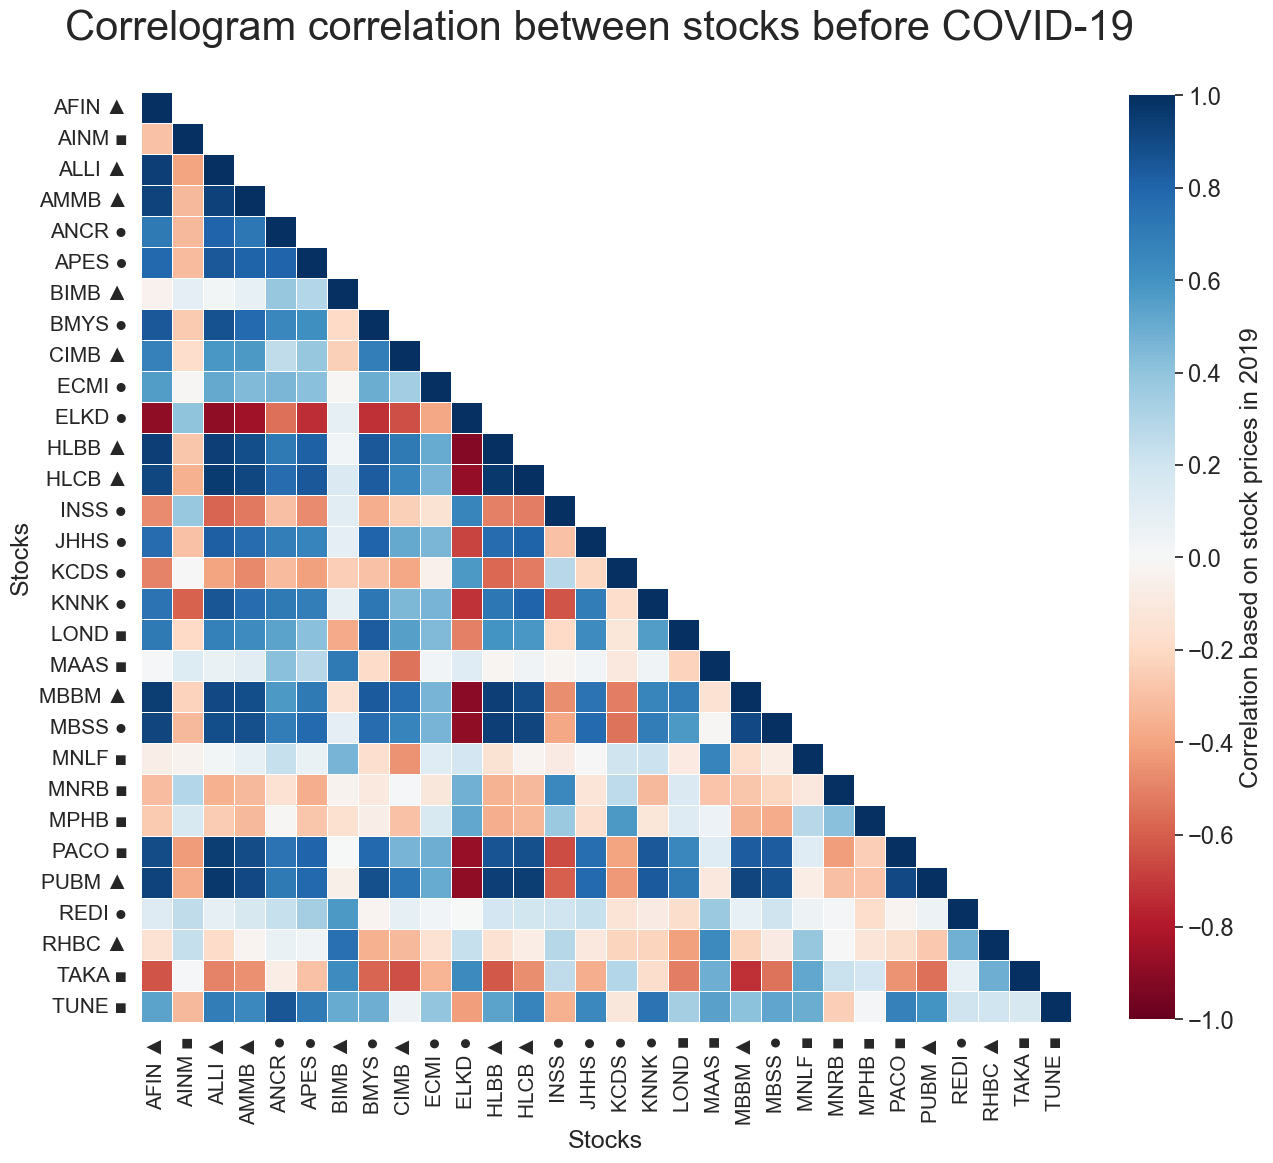

In [182]:
# Create a heatmap using Seaborn
sns.set()
#sns.set_theme(style="white")
sns.set_style("white")

cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


corr_df = cor_matrix.where(np.tril(np.ones(cor_matrix.shape)).astype(np.bool))

#mask = np.zeros_like(cor_matrix, dtype=np.bool_)
#mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 15))

ax = sns.heatmap(corr_df, xticklabels=1, yticklabels=1, cmap="RdBu", linewidths=.5, center=0,
                 square=True,vmin = -1.0, vmax=1.0,cbar_kws={"shrink": .8,
                                                             'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
                                                             'label': 'Correlation based on stock prices in 2019'})

g = plt.gca()


g.set_xticklabels(xy_label["label"])
g.set_yticklabels(xy_label["label"])

ax.figure.axes[-1].yaxis.label.set_size(18)
ax.figure.axes[-1].tick_params(labelsize=17)

plt.xlabel("Stocks",fontsize=18)
plt.ylabel("Stocks",fontsize=18)
plt.title(label="Correlogram correlation between stocks before COVID-19 \n",fontsize=30,loc="center")
plt.xticks(fontsize=15, rotation=90)  # Adjust rotation as needed
plt.yticks(fontsize=15)  # Adjust size for y-ticks
plt.savefig('Figure 2(a).jpg',dpi=500,bbox_inches = 'tight')
plt.show()

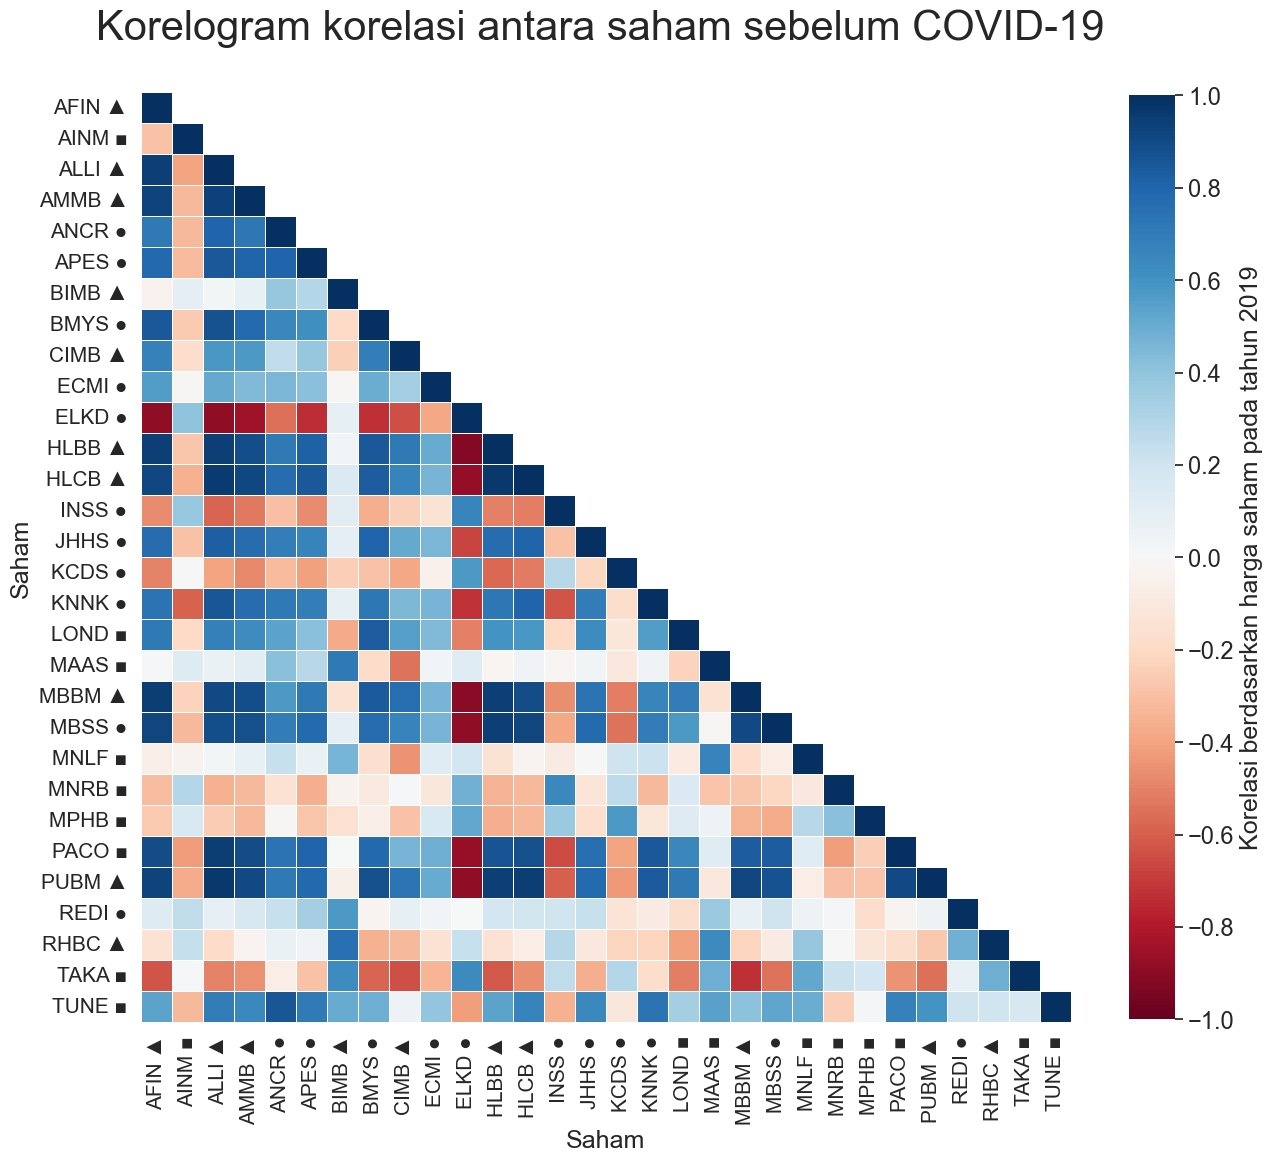

In [183]:
# Create a heatmap using Seaborn
sns.set()
#sns.set_theme(style="white")
sns.set_style("white")

cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


corr_df = cor_matrix.where(np.tril(np.ones(cor_matrix.shape)).astype(np.bool))

#mask = np.zeros_like(cor_matrix, dtype=np.bool_)
#mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 15))

ax = sns.heatmap(corr_df, xticklabels=1, yticklabels=1, cmap="RdBu", linewidths=.5, center=0,
                 square=True,vmin = -1.0, vmax=1.0,cbar_kws={"shrink": .8,
                                                             'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
                                                             'label': 'Korelasi berdasarkan harga saham pada tahun 2019'})

g = plt.gca()


g.set_xticklabels(xy_labelm["label"])
g.set_yticklabels(xy_labelm["label"])

ax.figure.axes[-1].yaxis.label.set_size(18)
ax.figure.axes[-1].tick_params(labelsize=17)

plt.xlabel("Saham",fontsize=18)
plt.ylabel("Saham",fontsize=18)
plt.title(label="Korelogram korelasi antara saham sebelum COVID-19 \n",fontsize=30,loc="center")
plt.xticks(fontsize=15, rotation=90)  # Adjust rotation as needed
plt.yticks(fontsize=15)  # Adjust size for y-ticks
plt.savefig('Figure 5.1.jpg',dpi=500,bbox_inches = 'tight')
plt.show()

Text(0.5, 1.0, 'Correlogram correlation between stocks before COVID-19')

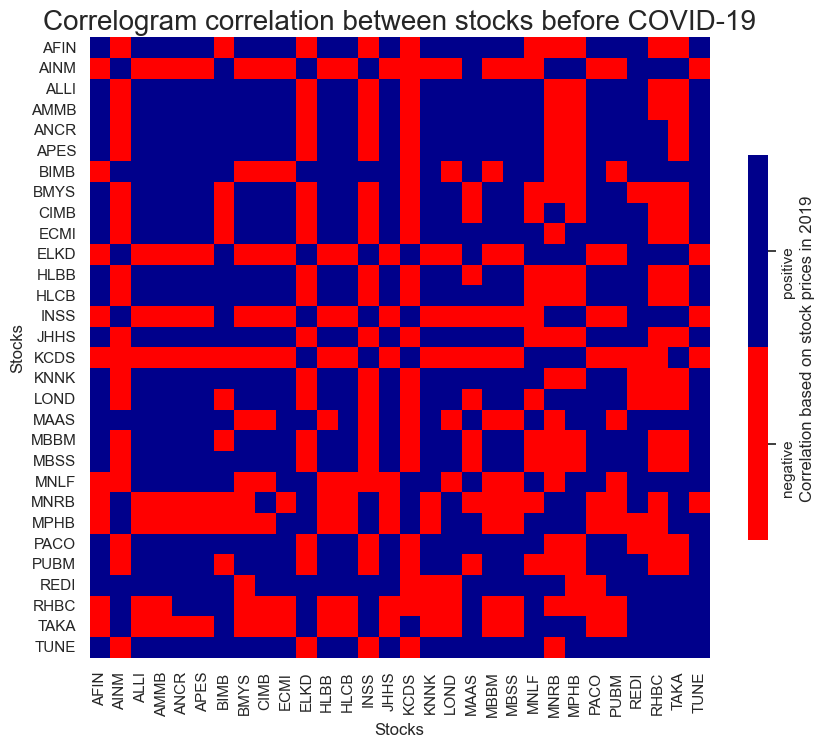

In [184]:
fig = plt.figure(figsize=(10, 10))
#df_heatmap = cor_matrix.pivot("Var1", "Var2", "Freq")

#sequential_colors = sns.color_palette("bright", 10)
# define the colors
cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])

# create a normalize object the describes the limits of
# each color
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

ax=sns.heatmap(cor_matrix,xticklabels=1, yticklabels=1, cmap= cmap, norm=norm, square=True,
           cbar_kws={"shrink": .5,'label': 'Correlation based on stock prices in 2019'})
plt.xlabel("Stocks")
plt.ylabel("Stocks")
# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.5,0.5])
colorbar.set_ticklabels(['negative', 'positive'], rotation=90)
plt.title(label="Correlogram correlation between stocks before COVID-19",fontsize=20,loc="center")

In [185]:
nx.write_gexf(Gx, 'G_2019.gexf')#networkx to Gephi